    can I run other python programs in a jupyter notebook? looks like no, instead import and execute all bits

In [80]:
import numpy as np
import astropy.table
import matplotlib as mpl
import matplotlib.pyplot as plt
import os,random,time
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits
import scipy.stats as ss
from astropy.modeling import models, fitting
import sys
from array import array
import pylab as pl
from IPython.display import IFrame


so let me outline what I want to do: for a given fits file that I'm analyzing:
1. read in a list of filenames from the eAA program
2. for each file (ap size) in that list, calculate the associated 5sigma depth and output it (append it to an array or dictionary)
3. for each file (ap size) produce a histogram of the data and a gaussian fit to it, then output the gaussian fit parameters (AND the histogram parameters, so I can plot them later all at once instead of one at a time?)
4. for each fits file I'm analyzing, calculate the rms--I don't think I can do this step without uploading .fits files, though, so consider doing it on the computer and making a lil file with all the rms functions in it that can be access later
5. for each object in list1, produce a plot of all the histograms/gaussian fits on top of each other
6. for each fits file I'm analyzing, produce a sigma-vs-linear-size plot (Labbe-esque

after looping through each object in the list, I will have a file of depth measurements, gaussian fits, and (maybe) histogram parameters, as well as the aperture sizes. then I want to
1. display all the histograms, with the x and y axis fixed so the fwhm change is visible; on top of each other would be good
2. plot the sigma-from-gaussian-fitting versus linear-size-of-apertures plot from Labbe 03 and overplot a y=mx+b relation for the gaussian rms (rms per pixel/size unit, * the linear-size-of-apertures, I assume. or a huge range in x/pixel/size, that's okay too)
3. make depth as a function of aperture size plot (basically the same as 2, but with the magnitudes instead of the sigmas and arcsec aps instead of linear size/pixels

So I need two parts to the program: one part that loops through the files in the filename list, and appends all the outputs; and another part that deals with the bulk outputs

In [91]:
def depthcalc(totfile,photvals):
    infile='../emptyApertureAnalysis_share/aperflux/'+str(totfile)
    valsin=np.loadtxt(infile,dtype=float,delimiter='\t',usecols=2,comments='#')
    tmpfile=infile
    tmplist=tmpfile.split('/')
    tmpname=tmplist[len(tmplist)-1]
    outname=tmpname.replace('.dat','')
    
    #########calculate average flux and stdev
    stdev_empty=np.std(valsin)
    avg_emptyflux=np.average(valsin)
    #########gaussian fit to histogram
    binnys=100
    #n,bins,patchs=plt.hist(valsin,binnys)
    hist1,bins1=np.histogram(valsin,binnys)
       
    
    #I want it to produce n, bins, and patches but I don't want it to actually plot
    #fit a gaussian to the resultant data
    holdhist={}
    model=models.Gaussian1D()
    fitter=fitting.LevMarLSQFitter()
    bestfit=fitter(model,bins1[0:(len(bins1)-1)],hist1)  #[0:np.size(bins)-1],n)
       #how do I output the parameters for fitting later? maybe just bestfit? or n,bins,patchs as well?
    holdhist={'hist1':valsin,'bins':bins1,'bestfit':bestfit}
    
    #do the fitting and save it to a file?
    #outfile=outname+str('.pdf')
    #plt.figure()
    #plt.hist(valsin,binnys)
    #plt.plot(bins1[0:np.size(bins1)-1],bestfit(bins1[0:np.size(bins1)-1]))
    #plt.title(outname)
    #plt.xlabel('electrons/s (intrinsic HST brightness in the filter)')
    #plt.ylabel('counts')
    #plt.savefig(outfile)
    #plt.close()

    #########set up parameters
    #I can't do any of this unless I upload a fits
    #hdu1=fits.open(fitsfilename)
    #hdr1=hdu1[0].header
    #temp_photflam=hdr1['PHOTFLAM']
    #temp_photplam=hdr1['PHOTPLAM']
    #temp_photfnu=hdr1['PHOTFNU']
    #temp_exptime=hdr1['EXPTIME']
    #hdu1.close()
    temp_photflam=photvals[0]
    temp_photplam=photvals[1]
    #########calculate abmag
    abmagzpt=-2.5*np.log10(temp_photflam) - 21.10 - 5.0*np.log10(temp_photplam) + 18.692
    abmag=-2.5*np.log10(5.0*stdev_empty)+abmagzpt
    
    return abmag,stdev_empty,holdhist,outname

In [92]:
filelist='../emptyApertureAnalysis_share/aperflux/j16_v8_allaps.txt'
filenames=np.loadtxt(filelist,dtype='str')

#normally I'd pull hold_photvals from the headers of the associated fits files
#but can't upload fits files to github so I just insert the values from the header manually here
hold_photvals=[1.9275602E-20,1.5369176E+04]
apers=np.array([0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0])

#set up output
abmags_all=[]
sigs_all=[]
histogram_info={}
keynames=[]

fits_sci='../../HSTdata/j160116m0029/j160116m0029-f160w_drz_sci.fits'
fits_mask='../../HSTdata/j160116m0029/j160116m0029-f160w_drz_sci_mask.fits'
fits_seg='../../sextractor-2.19.5/j16_f160w_seg_checkv8.fits'




#run 
for x in filenames:
    histdict={}
    mags,sigs,holdhists,nameout=depthcalc(x,hold_photvals)
    abmags_all.append(mags)
    sigs_all.append(sigs)
    histdict={nameout:holdhists}
    histogram_info.update(histdict)
    keynames.append(nameout)



okay that brings out all the data. now to plot, below

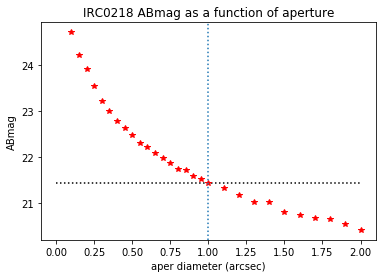

STDEV of all "valid" pixels in scidata: 0.010739323  this matches what is output as the RMS from the SE program
rms actual: 0.010758926
[0.00536966 0.00805449 0.01073932 0.01342415 0.01610898 0.01879381
 0.02147865 0.02416348 0.02684831 0.02953314 0.03221797 0.0349028
 0.03758763 0.04027246 0.04295729 0.04564212 0.04832695 0.05101178
 0.05369661 0.05906628 0.06443594 0.0698056  0.07517526 0.08054492
 0.08591458 0.09128424 0.0966539  0.10202357 0.10739323]


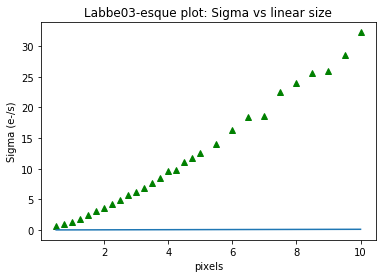

In [95]:
hdusci=fits.open(fits_sci)
hdumask=fits.open(fits_mask)
hduseg=fits.open(fits_seg)


#ABmag depth plot
plt.plot(apers,abmags_all,'r*')
plt.title('IRC0218 ABmag as a function of aperture')
plt.axvline(x=1.0,linestyle=':')
plt.hlines(y=21.45,xmin=0,xmax=2.0,linestyle=':')
plt.xlabel('aper diameter (arcsec)')
plt.ylabel('ABmag')
plt.show()


####Labbe03 plot
scidata=hdusci[0].data
maskdata=hdumask[0].data
segdata=hduseg[0].data
validpts=np.where((segdata<1) & (maskdata==1))
scivalid=scidata[validpts]

rmss=np.std(scivalid)
rmsactual=np.sqrt(np.mean(scivalid**2.0))
print('STDEV of all "valid" pixels in scidata:',rmss,' this matches what is output as the RMS from the SE program')
print('rms actual:',rmsactual)


pixscalef160w=0.1
pixscalef804w=0.05
aper1=0.5*np.array(apers)/pixscalef160w #times 1/2 for 'radius' rather than 'diameter' linear size
#is my linear size correct? N = sqrt(Area) ~ radius. above is radius in pixels


xvals=np.arange(0,20,0.1)
rmsvals=aper1*rmss
print(rmsvals)
#ok, if rms is average rms/pixel


plt.plot(aper1,sigs_all,'g^')
plt.title('Labbe03-esque plot: Sigma vs linear size')
plt.xlabel('pixels')
plt.ylabel('Sigma (e-/s)')
plt.plot(aper1,rmsvals) #replace second xvals with rmsvals once rmsvals are calculated and added to github
plt.show()


hdusci.close()
hdumask.close()
hduseg.close()


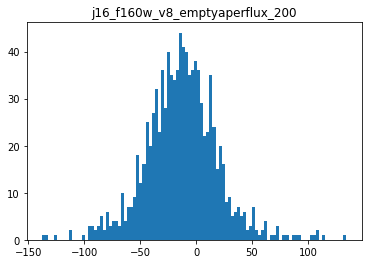

In [94]:
#plotting histograms and their gaussian fits
for y in keynames:
    binns=histogram_info[y]['bins']
    data=histogram_info[y]['hist1']
    bestfitp=histogram_info[y]['bestfit']
    #print(bestfitp)
    amps=histogram_info[y]['bestfit'].amplitude.value
    mn=histogram_info[y]['bestfit'].mean.value
    stde=histogram_info[y]['bestfit'].stddev.value
    plt.clf()
    plt.hist(data,100)
    plt.title(y)
        #plt.plot(binns[0:np.size(binns)-1],bestfitp[0:np.size(binns)-1])
    
    #okay, displaying individual gaussian fits is a pain in the butt--normally I'd just plt.plot(bins,bestfit(bins))
    #but that isn't working for whatever reason. bestfit is somehow a 1d gaussian thing that plt.plot can't handle